In [28]:
# Always import these into any notebook:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# What a derivative is and what info it gives us:

# Scalar function f(x)
def f(x):
    return 3*x**2 - 4*x + 5

In [30]:
f(3.0)

20.0

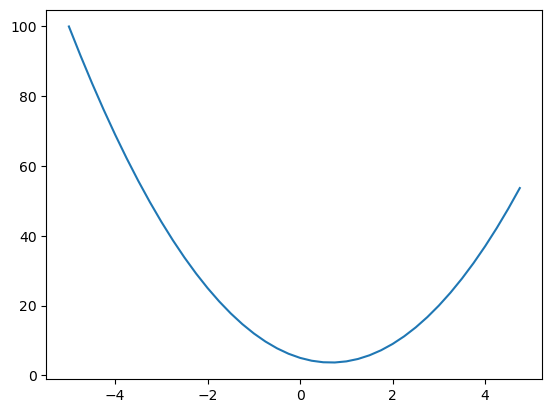

In [31]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [32]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x)) / h

14.00000009255109

In [34]:
h = 0.001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('Slope: ', (d2 - d1) / h)

d1 4.0
d2 3.997
Slope:  -3.0000000000001137


In [182]:
# We need data structures to hold massive expressions of Neural Networks

class Value:
    # Children: Helps us remember what values produce this value 
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data # Wraps scalar value
        self.grad = 0.0 # grad maintains the derivative w.r.t loss function, initialized to 0 because every value originally does not effect the loss function
        self._backward = lambda: None # A function that defaults to nothings -> defines how output node's gradient goes to children
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self): # Java toString
        return f"Value(data = {self.data})"
    
    def __add__(self, other): # Double underscore methods tells Python that "a + b" calls this method
        other = other if isinstance(other, Value) else Value(other) # Convert constants to Values
        out = Value(self.data + other.data, (self, other), '+')
        
        # All backward functions add onto their gradients because if a neuron is used multiple times, its gradient should be the sum of the influences on its parents.
        def _backward():
            self.grad += 1.0 * out.grad # Additions simply route gradient of output to input's gradient
            other.grad += 1.0 * out.grad # Additions simply route gradient of output to input's gradient
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Convert constants to Values
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad # Mutliplications mutliply other child's value with the output's gradient
            other.grad += self.data * out.grad # Mutliplications mutliply other child's value with the output's gradient
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    # Automatically calls _radd_ when other + self isn't possible.
    def __radd__(self, other): # Other + Self
        return self + other
    
    # Automatically calls _rmul_ when other * self isn't possible.
    def __rmul__(self, other): # Other * Self
        return self * other
    
    def __truediv__(self, other): # Self / Other
        return self * other**-1
    
    def __neg__(self): # -Self
        return self * -1
    
    def __sub__(self, other): # Self - Other
        return self + (-other)
    
    def tanh(self): # We only care about local derivatives of how inputs effect outputs
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        # out.grad is "global" derivative
        def _backward():
            self.grad += (1 - t**2) * out.grad # tan(t)' = (1 - t^2)
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # e^(x)' = e^(x)
        out._backward = _backward
        
        return out
    
    def backward(self):
        # Topological sort to ensure we only call backwards on a node once we know ALL its dependencies.
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: # Add everything but this node
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # Add this node at the end  
        build_topo(self)
        
        self.grad = 1.0 # Default because changing loss function by h increases it proprtionally by h.
        for node in reversed(topo):
            node._backward()

In [62]:
# An expression visualizer. Taken from Andrej's notebook:
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [183]:
# Calling tanh function as a whole:

# Inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# Weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# Bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

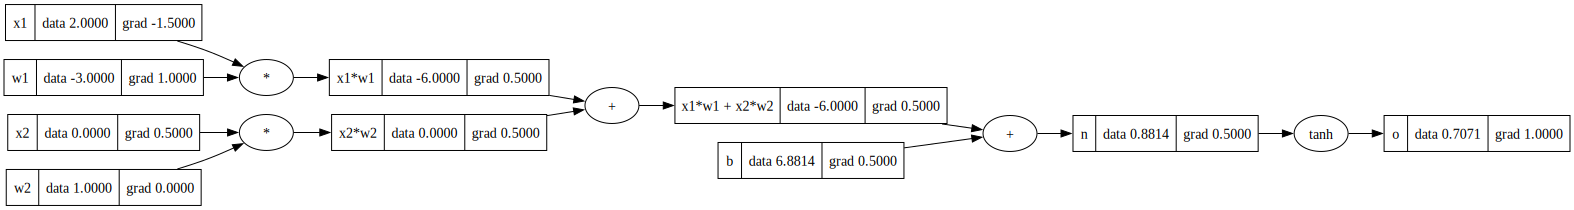

In [184]:
draw_dot(o)

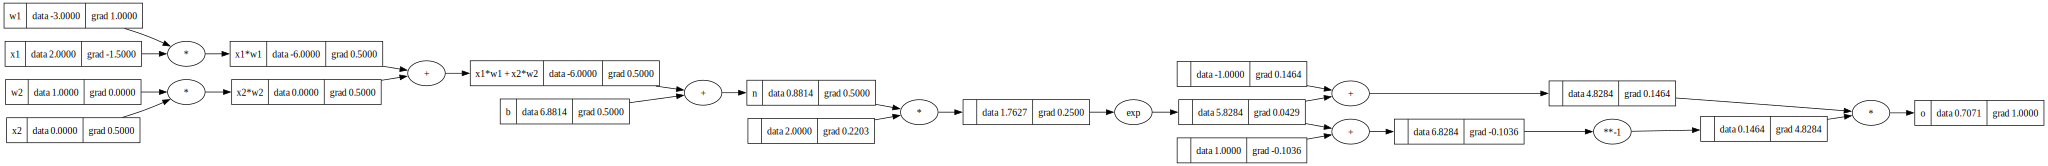

In [185]:
# tanh function built atomically:

# Inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# Weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# Bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

In [186]:
class Neuron:
    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # nin weights
        self.b = Value(random.uniform(-1, 1)) # bias ->  "trigger happiness"
        
    def __call__(self, x): # Calling n(x), where n = Neuron(nin)
        # w /dot x + b
        # Zip takes two iterators and create a new iterator that iterates over the tuples of their corresponding entries
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # Summation function; second parameter is the start value (bias) for the sum
        out = act.tanh() # Output once it goes through activation function
        return out
    
    def parameters(self):
        return self.w + [self.b] # Concatenate list of weights with bias
    
class Layer: # A list of neurons

    def __init__(self, nin, nout): # nout = how many neurons in layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # Call each neuron in the layer and put the output in a list
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:
    def __init__(self, nin, nouts): # nouts = list of sizes of each layer
        sz = [nin] + nouts # Combine sizes togther
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))] # List of layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # Call each layer
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [208]:
x = [2.0, 3.0, -1.0] # Inputs
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.48513911722078823)

In [209]:
# Data definition
xs = [
    [2.0 , 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [204]:
# Forward pass of Neural Network
ypred = [n(x) for x in xs]
print(ypred)
# yout = y-output and ygt = y-ground truth
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # We want to minimize this MSE loss
loss

[Value(data = 0.6828389227319565), Value(data = -0.8041119980570769), Value(data = 0.6785383993566645), Value(data = 0.3814087667041425)]


Value(data = 3.3391095302643397)

In [205]:
# Backward pass of Neural Network
loss.backward()

In [206]:
# Nudge weights and then start back at forward pass
a = 0.01 # Learning rate (alpha)
for p in n.parameters():
    p.data += -a * p.grad # Negative sign means to minimize loss -> go in opposite direction of gradient vector

In [207]:
ypred = [n(x) for x in xs]
print(ypred)

[Value(data = 0.6714986774495066), Value(data = -0.7958219282133516), Value(data = 0.6669826866691487), Value(data = 0.4100490896919414)]


In [210]:
# Gradient descent
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    
    # Evaluate loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Backward pass - adjust gradients AFTER resetting them to 0
    for p in n.parameters(): # Zero grad -> all the weights have a .data and a .grad. If we don't reset the gradients to 0, then .backward() would accumulate the gradients due to "+="
        p.grad = 0.0
    loss.backward()
    
    # Update weights
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 4.834879362314241
1 5.502468387032616
2 4.894799955324186
3 5.210093454045414
4 4.564098420287893
5 3.6395765209974584
6 4.119089935626076
7 0.30946818267486864
8 0.10294080486133238
9 0.07789264233557214
10 0.06256274884664251
11 0.05216860149298924
12 0.04466158676806762
13 0.038992262349846624
14 0.03456439685102803
15 0.031013846394310214
16 0.02810569776819494
17 0.025681693911122058
18 0.023631386393314628
19 0.021875391709397736


In [211]:
ypred

[Value(data = 0.938611308361788),
 Value(data = -0.9555952139808911),
 Value(data = -0.9109807253967793),
 Value(data = 0.9093876168724175)]